# step1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# step2. 각종 전처리 수행

In [2]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

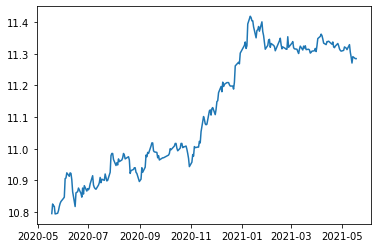

In [3]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# step3. 시계열 안정성 분석

In [38]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


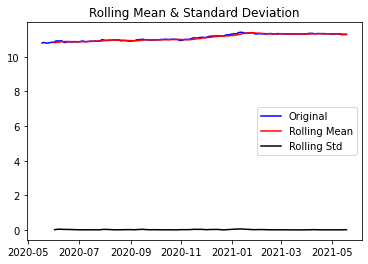

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


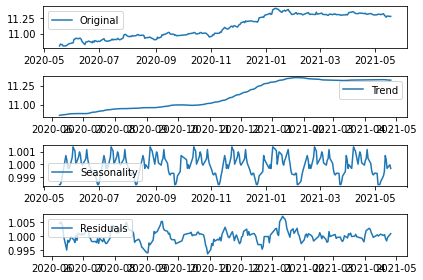

In [39]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# step4. 학습, 테스트 데이터셋 생성

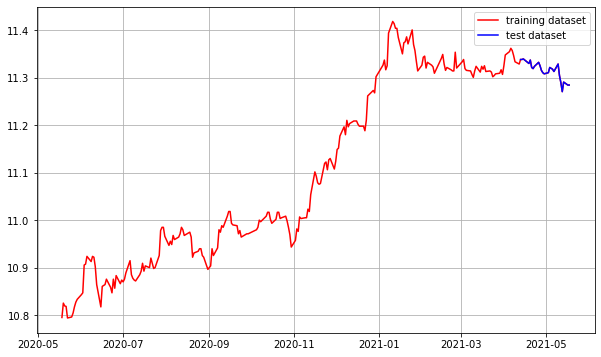

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# step5. 적정 ARIMA 모수 찾기

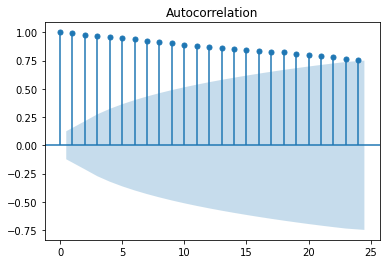

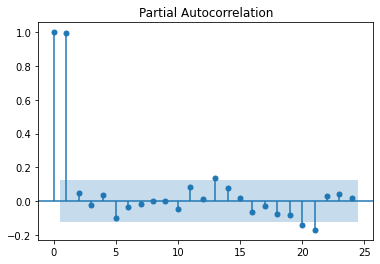

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


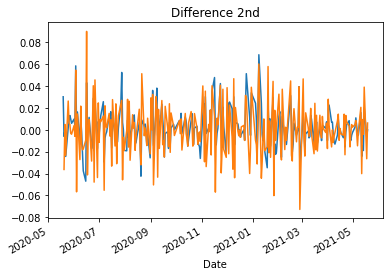

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# step6. ARIMA 모델 훈련과 테스트

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sat, 13 Nov 2021   AIC                          -1164.792
Time:                        14:41:23   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

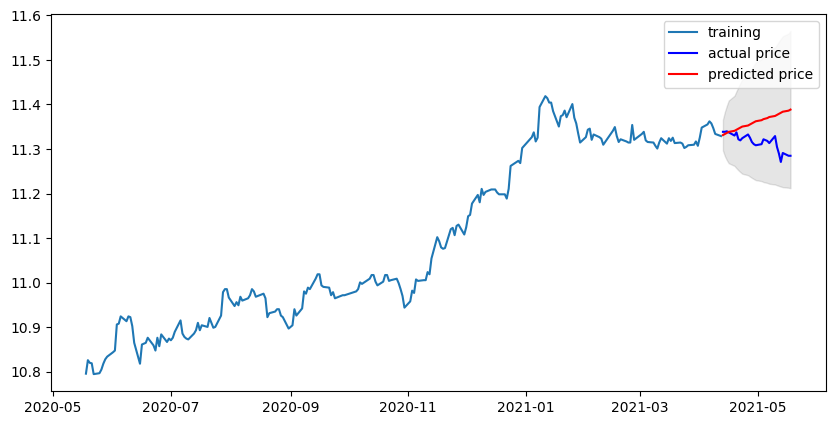

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


# step7. 다른 주식 종목 예측해보기

### 7-1 카카오

In [14]:
dataset_filepath2 = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2020-11-11    71100.0
2020-11-12    71500.0
2020-11-13    73100.0
2020-11-16    72400.0
2020-11-17    72400.0
Name: Close, dtype: float64

In [15]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

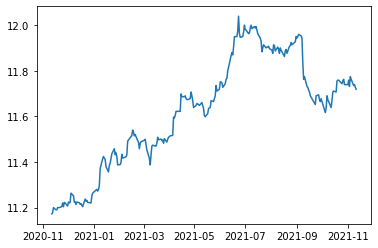

In [16]:
# 로그 변환 시도 
ts_log2 = np.log(ts2)
plt.plot(ts_log2)

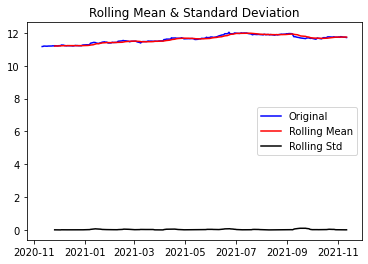

Results of Dickey-Fuller Test:
Test Statistic                  -1.816108
p-value                          0.372494
#Lags Used                       1.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


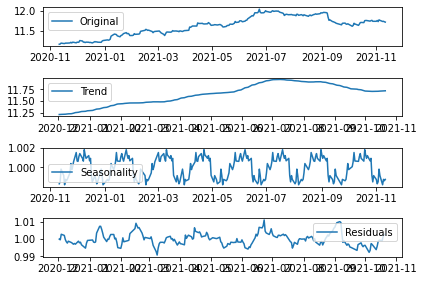

In [17]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log2, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log2)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(ts_log2, model='multiplicative', period = 30) 

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.061519
p-value                          0.000017
#Lags Used                       7.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


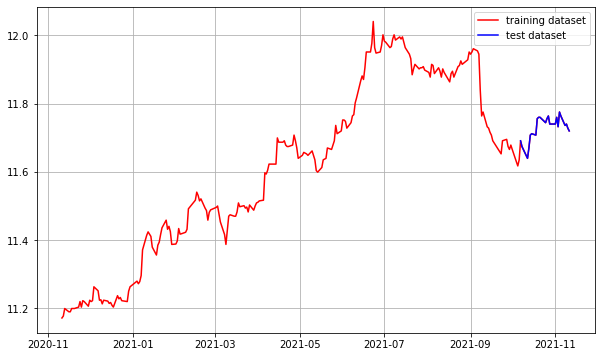

In [19]:
train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

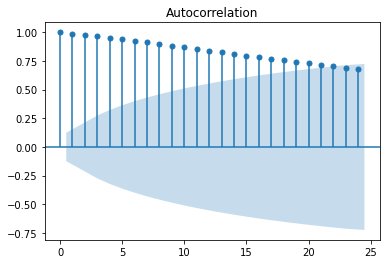

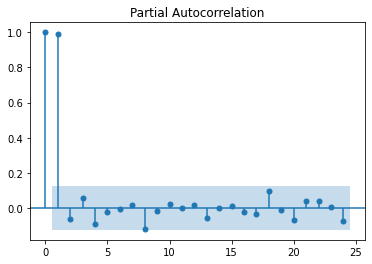

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.416985e+01
p-value                        2.012191e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.037053e+01
p-value                        2.270282e-18
#Lags Used                     6.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


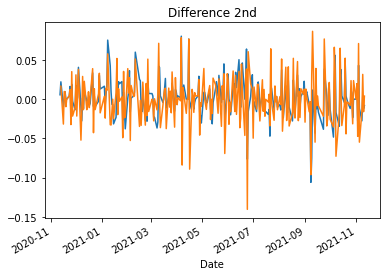

In [21]:
# 1차 차분 구하기
diff2_1 = ts_log2.diff(periods=1).iloc[1:]
diff2_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff2_1)

# 혹시 필요한 경우 2차 차분 구하기
diff2_2 = diff2_1.diff(periods=1).iloc[1:]
diff2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff2_2)

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model2 = ARIMA(train_data2, order=(1, 1, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 519.696
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sat, 13 Nov 2021   AIC                          -1033.393
Time:                        14:41:26   BIC                          -1023.185
Sample:                             1   HQIC                         -1029.271
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.002      1.181      0.237      -0.001       0.006
ar.L1.D.Close     0.1209      0.067      1.817      0.069      -0.010       0.251
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

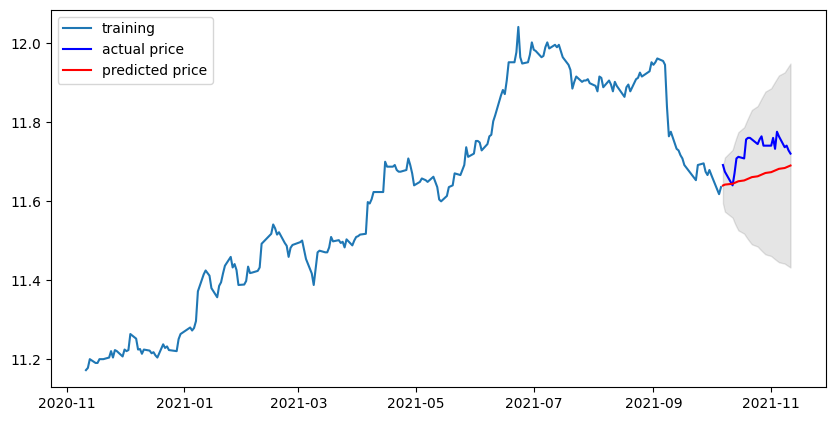

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc2, se2, conf2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과
lower_series2 = pd.Series(conf2[:, 0], index=test_data2.index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(conf2[:, 1], index=test_data2.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  75869981.05829751
MAE:  8067.251746329915
RMSE:  8710.337597263238
MAPE: 6.41%


### 7-2 sk하이닉스

In [24]:
dataset_filepath3 = os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df3 = pd.read_csv(dataset_filepath3, index_col='Date', parse_dates=True)
ts3 = df3['Close']

ts3.head()

Date
2020-11-11    87000.0
2020-11-12    88100.0
2020-11-13    89700.0
2020-11-16    98000.0
2020-11-17    98100.0
Name: Close, dtype: float64

In [25]:
# 결측치 처리
ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

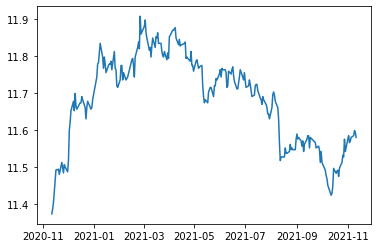

In [26]:
# 로그 변환 시도 
ts_log3 = np.log(ts3)
plt.plot(ts_log3)

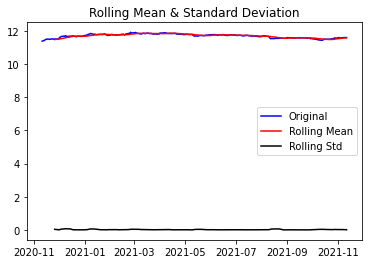

Results of Dickey-Fuller Test:
Test Statistic                  -2.511826
p-value                          0.112623
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


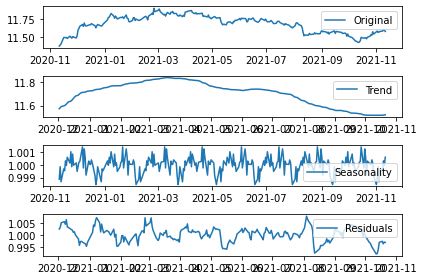

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log3, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log3)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition3 = seasonal_decompose(ts_log3, model='multiplicative', period = 30) 

trend3 = decomposition3.trend
seasonal3 = decomposition3.seasonal
residual3 = decomposition3.resid

plt.subplot(411)
plt.plot(ts_log3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [28]:
residual3.dropna(inplace=True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistic                  -4.890721
p-value                          0.000036
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


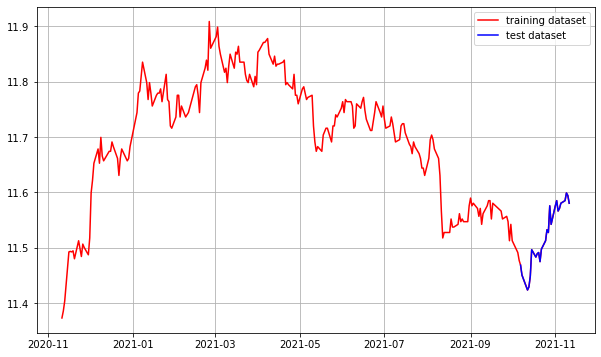

In [29]:
train_data3, test_data3 = ts_log3[:int(len(ts_log3)*0.9)], ts_log3[int(len(ts_log3)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log3, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()

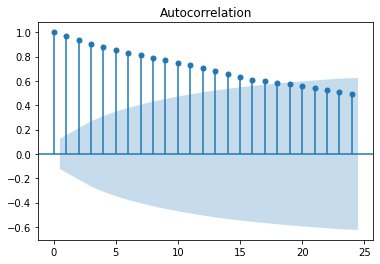

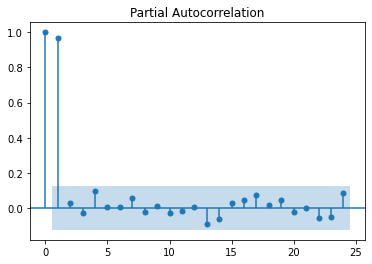

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.626678e+01
p-value                        3.520658e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.750997e+00
p-value                        2.836879e-14
#Lags Used                     1.000000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


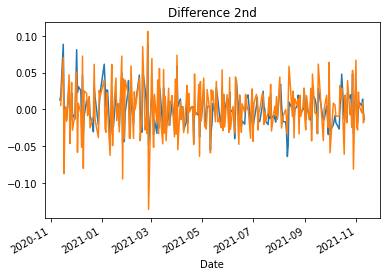

In [31]:
# 1차 차분 구하기
diff3_1 = ts_log3.diff(periods=1).iloc[1:]
diff3_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff3_1)

# 혹시 필요한 경우 2차 차분 구하기
diff3_2 = diff3_1.diff(periods=1).iloc[1:]
diff3_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff3_2)

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model3 = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 511.468
Method:                       css-mle   S.D. of innovations              0.024
Date:                Sat, 13 Nov 2021   AIC                          -1016.936
Time:                        14:41:29   BIC                          -1006.728
Sample:                             1   HQIC                         -1012.815
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.002      0.297      0.767      -0.003       0.004
ar.L1.D.Close    -0.0301      0.067     -0.449      0.653      -0.161       0.101
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

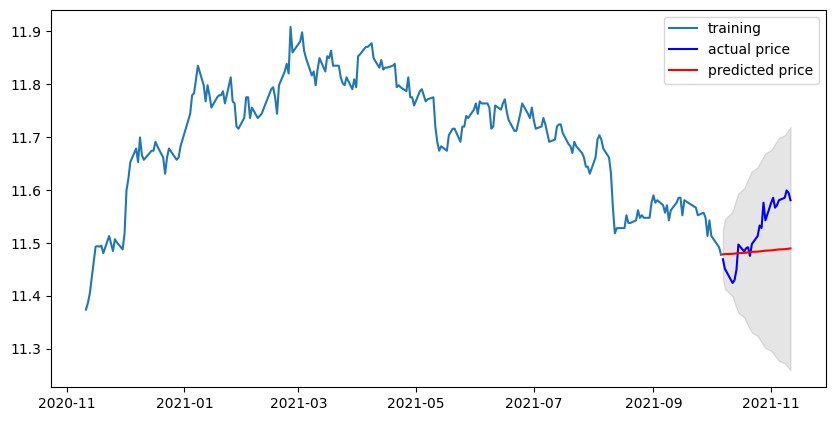

In [33]:
# Forecast : 결과가 fc에 담깁니다. 
fc3, se3, conf3 = fitted_m3.forecast(len(test_data3), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series3 = pd.Series(fc3, index=test_data3.index)   # 예측결과
lower_series3 = pd.Series(conf3[:, 0], index=test_data3.index)  # 예측결과의 하한 바운드
upper_series3 = pd.Series(conf3[:, 1], index=test_data3.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.fill_between(lower_series3.index, lower_series3, upper_series3, color='k', alpha=.10)
plt.legend()
plt.show()

In [35]:
mse3 = mean_squared_error(np.exp(test_data3), np.exp(fc3))
print('MSE: ', mse3)

mae3 = mean_absolute_error(np.exp(test_data3), np.exp(fc3))
print('MAE: ', mae3)

rmse3= math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3)))
print('RMSE: ', rmse3)

mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape3*100))

MSE:  43728792.12444392
MAE:  5451.886731131635
RMSE:  6612.774918628633
MAPE: 5.24%
